In [2]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame,Series
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target

In [3]:
import lightgbm as lgb

In [4]:
#读入数据
data = pd.read_csv(r'C:\Users\Apple\Desktop\data.csv',encoding='gbk')
#print(data.info())
data.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


0    3561
1    1193
Name: status, dtype: int64


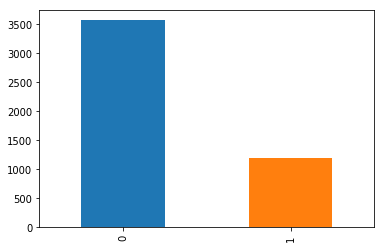

In [5]:
#查看结果的分布，好人和坏人的比例约为3:1
print(data['status'].value_counts())
data['status'].value_counts().plot(kind='bar')

In [6]:
#丢掉方差为0即没有变化的列
#df.drop(df.columns[df.std()==0],axis=1,inplace=True)
#df.shape

In [7]:
# #热力图研究相关性
# plt.figure(figsize=(54,46))
# corr=df.drop(['status'],axis=1).corr()
# #注意给lables值设置大小和格式,不然显示不清
# #show 列表名
# print(list(df))
# print(df.shape)
# sns.heatmap(corr,fmt='.2f',annot=True,cbar=False,annot_kws={'size':24,'weight':'bold'})

In [8]:
#计算缺失率和唯一率：删除一些不必要的列
data_1=pd.DataFrame(data.isnull().sum(),columns=['loss_num'])
data_2=pd.DataFrame(data.nunique(),columns=['unique_num'])
data_loss_unique=pd.merge(data_1,data_2,right_index=True,left_index=True)
data_loss_unique['loss_rate']=round(data_loss_unique['loss_num']/data.shape[0],5)
data_loss_unique['unique_rate']=round(data_loss_unique['unique_num']/data.shape[0],5)

data_loss_unique.head().T

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent
loss_num,0.0,0.0,0.0,0.00000,2.00000
unique_num,4754.0,4754.0,4754.0,1.00000,40.00000
loss_rate,0.0,0.0,0.0,0.00000,0.00042
unique_rate,1.0,1.0,1.0,0.00021,0.00841


In [9]:
#查看缺失比较验证的列
data_loss_unique.sort_values(by='loss_rate',ascending=False)

,loss_num,unique_num,loss_rate,unique_rate
student_feature,2998,2,0.63063,0.00042
cross_consume_count_last_1_month,426,19,0.08961,0.00400
latest_six_month_apply,304,65,0.06395,0.01367
latest_one_month_apply,304,36,0.06395,0.00757
latest_query_time,304,207,0.06395,0.04354
query_sum_count,304,74,0.06395,0.01557
query_cash_count,304,17,0.06395,0.00358
query_finance_count,304,25,0.06395,0.00526
query_org_count,304,46,0.06395,0.00968
apply_credibility,304,41,0.06395,0.00862


In [10]:
#查看唯一值情况 唯一率特别高或者特别低的都可以考虑删除
data_loss_unique.sort_values(by='unique_rate',ascending=False)

,loss_num,unique_num,loss_rate,unique_rate
Unnamed: 0,0,4754,0.00000,1.00000
trade_no,0,4754,0.00000,1.00000
custid,0,4754,0.00000,1.00000
historical_trans_amount,0,4524,0.00000,0.95162
id_name,276,4309,0.05806,0.90639
trans_amount_3_month,0,3524,0.00000,0.74127
pawns_auctions_trusts_consume_last_6_month,0,2730,0.00000,0.57425
repayment_capability,0,2390,0.00000,0.50273
consume_mini_time_last_1_month,26,1971,0.00547,0.41460
abs,0,1697,0.00000,0.35696


In [11]:
data.columns

Index(['Unnamed: 0', 'custid', 'trade_no', 'bank_card_no',
       'low_volume_percent', 'middle_volume_percent',
       'take_amount_in_later_12_month_highest',
       'trans_amount_increase_rate_lately', 'trans_activity_month',
       'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter',
       'trans_days_interval', 'regional_mobility', 'student_feature',
       'repayment_capability', 'is_high_user', 'number_of_trans_from_2011',
       'first_transaction_time', 'historical_trans_amount',
       'historical_trans_day', 'rank_trad_1_month', 'trans_amount_3_month',
       'avg_consume_less_12_valid_month', 'abs',
       'top_trans_count_last_1_month', 'avg_price_last_12_month',
       'avg_price_top_last_12_valid_month', 'reg_preference_for_trad',
       'trans_top_time_last_1_month', 'trans_top_time_last_6_month',
       'consume_top_time_last_1_month', 'consume_top_time_last_6_month',
       'cross_consume_count_last_1_month',
       'trans_fail_top_count_enum_last_1_mont

In [12]:
data.shape

(4754, 90)

In [13]:
#综合上面两张表，可以得出：student_feature缺失严重，删掉；num、custid、id_name唯一率较高，无意义，可删掉；
#bank_card_no、trade_no、source唯一率极低，且无意义，删掉
columns_drop=['student_feature','bank_card_no','source','trade_no','id_name','Unnamed: 0','custid']
data.drop(columns=columns_drop,axis=1,inplace=True)

In [14]:
data.shape

(4754, 83)

In [15]:
#obj对象需要进一步处理reg_preference_for_trad 、latest_query_time、loans_latest_time
data.select_dtypes('object').columns

Index(['reg_preference_for_trad', 'latest_query_time', 'loans_latest_time'], dtype='object')

In [16]:
data['reg_preference_for_trad'].unique()

array(['一线城市', '三线城市', '境外', '二线城市', '其他城市', nan], dtype=object)

In [17]:
#处理latest_query_time、loans_latest_time，这两个日期与当前时间的差值是有意义的
data['latest_query_time'] = pd.to_datetime(data['latest_query_time'], format ='%Y-%m-%d')
data['loans_latest_time'] = pd.to_datetime(data['loans_latest_time'], format ='%Y-%m-%d')
today=pd.to_datetime('2019-5-13', format ='%Y-%m-%d')

data['loan_last_days']=abs(data['loans_latest_time']-today)
data['query_last_days']=abs(data['latest_query_time']-today)

for i,j in enumerate(data['loan_last_days']):
    data['loan_last_days'][i]=j.days

for i,j in enumerate(data['query_last_days']):
    data['query_last_days'][i]=j.days

data['loan_last_days']=data['loan_last_days'].astype('float')
data['query_last_days']=data['query_last_days'].astype('float')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [18]:
#处理完差值之后，删掉'latest_query_time','loans_latest_time'这两个无用变量
data.drop(['latest_query_time','loans_latest_time'],axis=1,inplace=True)

#之后查看数据情况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4752 non-null float64
first_transacti

In [19]:
data.shape

(4754, 83)

In [20]:
#接下来步骤，填充缺失值

In [21]:
data.select_dtypes('object').columns

Index(['reg_preference_for_trad'], dtype='object')

代码一/方法一

In [22]:
#处理缺失值，方法一
null=pd.DataFrame(data.isnull().sum(),columns=['num'])
null.astype('float')


null_lst=[]
for i,j in enumerate(null['num']):
    if j>0:
        null_lst.append(null.index[i])

#用众数填充，没有区分数值型和obj型，如果想用median中位数填充，需要区分数值型，参考代码二
for i in null_lst:
    fill_value=data[i].value_counts().index[0]
    data[i].fillna(fill_value, inplace=True)

代码二/方法二

In [23]:
##生成一个字典、代码二/方法二
#dict1=data.isnull().sum()
##
##去除缺失值为0的键值对，同时去除去除缺失值大于2000的键值对，这些稍后处理
#for i in list(dict1.keys()):
#    if dict1[i]==0:
#        del dict1[i]
##
#for j in list(dict1.keys()):
#    if dict1[j]>2000:
#        del dict1[j]
#len(dict1)
##
## 数值型数据中位数填充
#for key in dict1.keys():
#    if data[key].dtype != object:
#        data[key].fillna(data[key].median(),inplace = True)
#    else:
#        print('object类型的缺失值和个数',key,dict1[key])

In [24]:
pd.value_counts(data.status)

0    3561
1    1193
Name: status, dtype: int64

In [25]:
data[['reg_preference_for_trad','status']].groupby(data['reg_preference_for_trad'])['status'].count().reset_index()

,reg_preference_for_trad,status
0,一线城市,3405
1,三线城市,1064
2,二线城市,131
3,其他城市,4
4,境外,150


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

In [27]:
data.shape

(4754, 83)

In [28]:
data.select_dtypes('object').columns

Index(['reg_preference_for_trad'], dtype='object')

In [29]:
data_1=data.join(pd.get_dummies(data['reg_preference_for_trad']))
data_1

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,...,1200.0,12.0,18.0,389.0,383.0,1,0,0,0,0
1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,...,9360.0,4.0,2.0,373.0,375.0,1,0,0,0,0
2,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,...,4200.0,2.0,6.0,377.0,373.0,1,0,0,0,0
3,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,...,12180.0,2.0,4.0,375.0,373.0,0,1,0,0,0
4,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,...,8250.0,22.0,120.0,491.0,393.0,1,0,0,0,0
5,0.02,0.98,2000,7.59,1.00,0.733,27.0,8.0,11.0,3.0,...,8130.0,3.0,4.0,375.0,374.0,0,1,0,0,0
6,0.02,0.98,0,23.67,0.94,0.087,10.0,54.0,53.0,2.0,...,8900.0,1.0,3.0,374.0,372.0,1,0,0,0,0
7,0.02,0.98,0,0.25,0.88,0.302,19.0,20.0,20.0,2.0,...,0.0,23.0,4.0,375.0,394.0,1,0,0,0,0
8,0.03,0.65,0,0.31,0.76,0.472,15.0,21.0,14.0,2.0,...,7987.0,24.0,7.0,378.0,395.0,0,1,0,0,0
9,0.01,0.99,500,0.80,1.00,0.088,15.0,36.0,35.0,2.0,...,0.0,18.0,142.0,516.0,392.0,1,0,0,0,0


In [30]:
data_1.drop(columns=['reg_preference_for_trad'],axis=1,inplace=True)

In [31]:
data_1.shape

(4754, 87)

In [30]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 87 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

In [32]:
data_1[['一线城市', '三线城市', '境外', '二线城市', '其他城市']]=data_1[['一线城市', '三线城市', '境外', '二线城市', '其他城市']].astype('float')

In [33]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 87 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

In [34]:
#区分X和Y
data_y=pd.DataFrame(data_1['status'])

In [35]:
data_y.shape

(4754, 1)

In [36]:
data_x=data_1.drop('status',axis=1,inplace=False)

In [37]:
data_x.shape

(4754, 86)

# 归一化MinMaxScaler和StandardScaler

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

min_max_scaler=MinMaxScaler()
std_scaler=StandardScaler()

In [39]:
data_x_std=pd.DataFrame(std_scaler.fit_transform(data_x),columns=data_x.columns)
data_x_min_max=pd.DataFrame(min_max_scaler.fit_transform(data_x),columns=data_x.columns)

In [40]:
#均值方差归一化
data_x_std

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,-0.284251,0.612259,-0.494499,-0.019099,-1.292504,-0.307656,-0.112457,-0.088274,0.258136,0.360860,...,-1.081880,-0.329940,-0.638272,-0.649898,-0.347656,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
1,-0.043372,0.267007,0.015242,-0.018551,0.992929,0.544402,0.334549,0.043831,-0.470448,1.484325,...,0.317762,-0.549139,-0.938777,-0.950288,-0.567080,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
2,0.438384,0.405108,-0.494499,-0.018955,0.992929,-1.477031,-1.006468,1.717157,0.015275,-1.886068,...,-0.567306,-0.603939,-0.863651,-0.875190,-0.621936,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
3,-0.525129,0.405108,0.015242,-0.020208,-1.190929,2.418929,1.005058,-0.660727,-0.956171,0.360860,...,0.801462,-0.603939,-0.901214,-0.912739,-0.621936,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
4,-0.284251,0.612259,-0.494499,-0.019733,0.992929,-1.118579,-1.006468,1.629087,1.229582,-1.886068,...,0.127370,-0.055941,1.277445,1.265084,-0.073376,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
5,-0.043372,0.543209,0.015242,-0.009457,0.992929,2.160373,2.122572,-0.924936,-0.652594,0.360860,...,0.106787,-0.576539,-0.901214,-0.912739,-0.594508,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
6,-0.043372,0.543209,-0.494499,0.013716,0.688205,-1.635690,-1.676977,1.100668,1.897451,-0.762604,...,0.238861,-0.631339,-0.919995,-0.931513,-0.649364,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
7,-0.043372,0.543209,-0.494499,-0.020035,0.383480,-0.372295,0.334549,-0.396518,-0.106156,-0.762604,...,-1.287710,-0.028541,-0.901214,-0.912739,-0.045948,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
8,0.197506,-1.735454,-0.494499,-0.019949,-0.225969,0.626670,-0.559462,-0.352483,-0.470448,-0.762604,...,0.082259,-0.001141,-0.844869,-0.856416,-0.018520,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
9,-0.284251,0.612259,-0.367064,-0.019243,0.992929,-1.629814,-0.559462,0.308040,0.804574,-0.762604,...,-1.287710,-0.165540,1.690639,1.734442,-0.100804,0.629430,-0.536979,-0.168335,-0.029019,-0.180500


In [41]:
#0-1归一化：（x-min）/（max-min）
data_x_min_max

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,0.01,0.99,0.000000,0.000019,0.488636,0.308370,0.375,0.094737,0.095652,0.50,...,0.014493,0.038674,0.061538,0.052308,0.033333,1.0,0.0,0.0,0.0,0.0
1,0.02,0.94,0.029412,0.000027,1.000000,0.468062,0.425,0.105263,0.043478,0.75,...,0.113043,0.016575,0.012308,0.003077,0.011111,1.0,0.0,0.0,0.0,0.0
2,0.04,0.96,0.000000,0.000021,1.000000,0.089207,0.275,0.238596,0.078261,0.00,...,0.050725,0.011050,0.024615,0.015385,0.005556,1.0,0.0,0.0,0.0,0.0
3,0.00,0.96,0.029412,0.000003,0.511364,0.819383,0.500,0.049123,0.008696,0.50,...,0.147101,0.011050,0.018462,0.009231,0.005556,0.0,1.0,0.0,0.0,0.0
4,0.01,0.99,0.000000,0.000010,1.000000,0.156388,0.275,0.231579,0.165217,0.00,...,0.099638,0.066298,0.375385,0.366154,0.061111,1.0,0.0,0.0,0.0,0.0
5,0.02,0.98,0.029412,0.000159,1.000000,0.770925,0.625,0.028070,0.030435,0.50,...,0.098188,0.013812,0.018462,0.009231,0.008333,0.0,1.0,0.0,0.0,0.0
6,0.02,0.98,0.000000,0.000497,0.931818,0.059471,0.200,0.189474,0.213043,0.25,...,0.107488,0.008287,0.015385,0.006154,0.002778,1.0,0.0,0.0,0.0,0.0
7,0.02,0.98,0.000000,0.000005,0.863636,0.296256,0.425,0.070175,0.069565,0.25,...,0.000000,0.069061,0.018462,0.009231,0.063889,1.0,0.0,0.0,0.0,0.0
8,0.03,0.65,0.000000,0.000007,0.727273,0.483480,0.325,0.073684,0.043478,0.25,...,0.096461,0.071823,0.027692,0.018462,0.066667,0.0,1.0,0.0,0.0,0.0
9,0.01,0.99,0.007353,0.000017,1.000000,0.060573,0.325,0.126316,0.134783,0.25,...,0.000000,0.055249,0.443077,0.443077,0.058333,1.0,0.0,0.0,0.0,0.0


# 计算iv值

In [42]:
#返回每一列上下1.5倍iqr之间的值，长度会不一样
def error_values_filter(x):
        
    desc_df=x.describe()
    L=desc_df.loc['25%']
    R=desc_df.loc['75%']
    IQR=R-L
    IQR_UP=R+1.5*IQR
    IQR_LOW=L-1.5*IQR
    x=np.array(x.values)
    temp=x[np.where((x>IQR_LOW) &(x<IQR_UP))]

    return temp

In [43]:
error_values_filter(data_x_std.apply_score)

array([ 0.1697572 ,  1.56478872,  1.58471774, ...,  1.62457578,
        1.48507263, -0.60747464])

In [44]:
error_values_filter(data_x_std.apply_score).shape

(4754,)

In [45]:
# 对连续型特征进行离散化,返回的是x中每个元素最终被分在了第几组，如下代码
def discrete(x):
    res = np.array([0] * x.shape[0], dtype=int)
    for i in range(5):
        #point1和point2是计算x的分位数,第一步计算0分位数point1和20分位数point2，x1是处在这两个数之间的索引
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        #x1返回的是x中满足条件的索引
        x1 = x[np.where((x >= point1) & (x <= point2))]
        #mask返回一个与x相同长度的布尔数组，当x1中的元素在x中，则为True，否则为False。
        mask = np.in1d(x, x1)
        #res定义每一个元素最终被分在了那个组
        res[mask] = (i + 1)
    return res

In [46]:
discrete(data_x_std.apply_score.values)

array([4, 5, 5, ..., 5, 5, 3])

In [51]:
from sklearn.utils.multiclass import type_of_target
#x_type = type_of_target(x)
#返回x的数据类型continuous、continuous-multioutput、binary、multiclass、multiclass-multioutput、multilabel-indicator、unknown


#判断特征数据是否为离散型
def feature_discretion(X):
    temp = []
    for i in range(X.shape[-1]):
        #选取X的某一列
        x = X.values[:, i]
        #判断x的数据类型
        x_type = type_of_target(x)
        #x.dtype !='0':
        if pd.Series(list(x)).dtype != 'O':
            x1 = discrete(x)
            temp.append(x1)
        else:
            temp.append(x)
    return np.array(temp).T

In [52]:
feature_discretion(data_x_std)

array([[3, 5, 2, ..., 5, 5, 5],
       [4, 3, 4, ..., 5, 5, 5],
       [5, 3, 2, ..., 5, 5, 5],
       ...,
       [1, 5, 5, ..., 5, 5, 5],
       [5, 3, 2, ..., 5, 5, 5],
       [3, 5, 4, ..., 5, 5, 5]])

In [53]:
#计算坏人个数和好人个数
def count_binary(a, event):
    event_count = (a.values == event).sum()
    non_event_count = a.shape[0] - event_count
    return event_count, non_event_count

In [54]:
count_binary(data_y,event=1)

(1193, 3561)

In [55]:
#求单个特征的woe值
def iv_single_x(x, y, event):
    event_total, non_event_total = count_binary(y, event) #计算好人坏人总数
    x_labels = np.unique(x) #特征中的分段
    woe_dict = {}  #存放每个分段的名称 以及 其对应的woe值
    iv = 0
    for x1 in x_labels: #遍历每个分段
        y1 = y.values[np.where(x == x1)[0]]
        event_count, non_event_count = count_binary(pd.DataFrame(y1), event=event)
        rate_event = 1.0 * event_count / event_total
        rate_non_event = 1.0 * non_event_count / non_event_total
        #woe无穷大时处理
        if rate_event == 0:
            print()#print("{'",x1,"'}"+":全是好人") #只输出不做处理
        elif rate_non_event == 0:
            print()#print("{'",x1,"'}"+":全是坏人")
        else:
            woe1 = math.log(rate_event / rate_non_event)
            woe_dict[x1] = woe1  
            iv += (rate_event - rate_non_event) * woe1
    return iv

In [56]:
iv_single_x(data_x_std.apply_score,data_y,event=1)

0.482723098869688

In [57]:
#求woe值和iv值
def iv(X, y, event):
    #res_woe = []  #列表存放woe字典
    res_iv = []  #列表存放iv
    X1 = feature_discretion(X) #对连续型特征进行处理
    for i in range(0, X1.shape[-1]):  #遍历所有特征
        x = X1[:, i]  #单个特征
        #woe_dict, iv1 = woe_single_x(x, y, event)  #计算单个特征的woe值
        iv1 = iv_single_x(x, y, event)
        #res_woe.append(woe_dict)
        res_iv.append(iv1)

    return res_iv
    #return np.array(res_woe), np.array(res_iv)  #返回数组

In [58]:
iv(data_x_std,data_y,event=1)

[0.015758464341711475,
 0.014966378640935883,
 0.0036529979445122174,
 0.02123383217691837,
 0.008734243733717386,
 0.0038874448764744376,
 0.0031735379078753007,
 0.007813752154622843,
 0.019066262366466517,
 0.005447203245074106,
 0.0023830286003390937,
 0.0,
 0.014135470481267079,
 0.014359740620043186,
 0.0133526343186138,
 0.011304165931636,
 0.10571216621907438,
 0.03749800010580736,
 0.004772591842244437,
 0.005612717024492344,
 0.06848396063931482,
 0.03506705108739377,
 0.03044040109363722,
 0.08368488268528734,
 0.010605813442558065,
 0.03534812829716833,
 0.00827623880699932,
 0.007707664759880788,
 0.5466192197469291,
 0.2625434456191418,
 0.2550296070853412,
 0.013789230015693852,
 0.10619295459906644,
 0.002525433483481722,
 0.0,
 0.05664026697293398,
 0.016166060857212575,
 0.0,
 0.015126623945289179,
 0.07736510546241304,
 0.37183829845167715,
 0.0013886642587715417,
 0.0059247708759970355,
 0.0057230496596788845,
 0.01783488578023098,
 0.0031980533411300168,
 0.0109109

In [59]:
def X_iv(X, y, event):
    dic_iv={}
    result=iv(X, y, event)
    for i,j in enumerate(X.columns):
        dic_iv[j]=result[i]
    iv_df=pd.DataFrame({'feature':list(dic_iv.keys()),'iv':list(dic_iv.values())}).sort_values(by='iv',ascending=False)
    return iv_df

In [60]:
data_x_iv_df=X_iv(X=data_x_std, y=data_y, event=1)

In [62]:
data_x_iv_df.shape

(86, 2)

In [63]:
data_x_by_iv=data_x_iv_df[data_x_iv_df['iv']>0.03]

In [64]:
list(data_x_by_iv.feature.values)

['trans_fail_top_count_enum_last_1_month',
 'history_fail_fee',
 'loans_score',
 'apply_score',
 'loans_overdue_count',
 'trans_fail_top_count_enum_last_6_month',
 'trans_fail_top_count_enum_last_12_month',
 'latest_one_month_fail',
 'latest_one_month_suc',
 'max_cumulative_consume_later_1_month',
 'rank_trad_1_month',
 'trans_top_time_last_1_month',
 'trans_day_last_12_month',
 'top_trans_count_last_1_month',
 'pawns_auctions_trusts_consume_last_1_month',
 'consfin_avg_limit',
 'trans_amount_3_month',
 'query_last_days',
 'consume_top_time_last_1_month',
 'avg_price_last_12_month',
 'latest_query_day',
 'avg_price_top_last_12_valid_month']

In [65]:
data_x_std_byiv=data_x_std[list(data_x_by_iv.feature.values)]

In [66]:
data_x_std_byiv.shape

(4754, 22)

In [67]:
data_y.shape

(4754, 1)

# 数据集切分

In [163]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x_std_byiv, data_y, test_size=0.2, random_state=2017)

# 模型训练

In [69]:
#模型训练--暂时先不调参
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve

lr_model = LogisticRegression()
svm_model = svm.SVC(probability=True)
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier()
knn_model=KNeighborsClassifier()
#gbdt_model=GradientBoostingClassifier(n_estimators=100)
rf_model=RandomForestClassifier()


#models={'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
#        'xgboost':xgb_model,'random forest':rf_model}

# 网格搜索--调参

In [70]:
from sklearn.model_selection import GridSearchCV

lr_model_param=[{'penalty':[i for i in ['l1','l2']]}]

svm_model_param=[{'kernel':[i for i in ['rbf','linear','poly','sigmoid']]}]

dt_model_param=[{'criterion': [i for i in ['entropy','gini']]}]

xgb_model_param=[{'eta': list(np.linspace(0.1,0.5,21)),'max_depth':[i for i in range(3,10)]}]

knn_model_param=[
    {'weights':['uniform'],
     'n_neighbors':[i for i in range(1,11)]
    },
    {'weights':['distance'],
     'n_neighbors':[i for i in range(1,11)],
     'p':[i for i in range(1,6)]
    }]

rf_model_param=[{'n_estimators':list(int(i) for i in list(np.linspace(10,50,9))),
                 'min_samples_split':list(np.linspace(0.1,0.9,9))}]

In [71]:
#grid_search=GridSearchCV(knn_model,knn_model_param)

In [72]:
#%%time
##耗时较长，遍历所有的情况
#grid_search.fit(x_train,y_train)

In [73]:
#best_params=grid_search.best_params_

In [74]:
#best_estimator=grid_search.best_estimator_

In [75]:
lst_param=[lr_model_param,svm_model_param,knn_model_param,dt_model_param,xgb_model_param,rf_model_param]

model=[lr_model,svm_model,knn_model,dt_model,xgb_model,rf_model]

model_name=['lr_model','svm_model','knn_model','dt_model','xgb_model','rf_model']

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
%%time
best_param={}
best_model={}
for i in range(len(lst_param)):
    grid_search=GridSearchCV(model[i],lst_param[i])
    grid_search.fit(x_train,y_train)
    best_model[model_name[i]]=grid_search.best_estimator_
    best_param[model_name[i]]=grid_search.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Wall time: 18min 21s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [80]:
#parms_df=pd.DataFrame({'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
 #       'xgboost':xgb_model,'random forest':rf_model})

In [81]:
parms_df=pd.DataFrame({'LR':best_model['lr_model'],'svm':best_model['svm_model'],
                       'knn':best_model['knn_model'],'decision tree':best_model['dt_model'],
                       'xgboost':best_model['xgb_model'],'random forest':best_model['rf_model']})

In [82]:
#parms_df=pd.DataFrame({'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
#        'xgboost':xgb_model,'gbt':gbdt_model,'random forest':rf_model})

In [83]:
df_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])

In [84]:
#定义评价函数,根据y_pred和y_test返回acc,p,r和f1值
def evaluate(y_pred,y_test):
    acc=accuracy_score(y_test,y_pred)
    p=precision_score(y_test,y_pred)
    r=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)

    return acc,p,r,f1

In [85]:
#进一步每个模型model进行迭代,并将df_result进行填充,并计算auc值
row=0  
for name,model in best_model.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    y_pred_proba=model.predict_proba(x_test)[:,1]
    acc,p,r,f1=evaluate(y_pred,y_test)
    auc=roc_auc_score(y_test,y_pred_proba)
    df_result.loc[row]=[name,acc,p,r,f1,auc]
    row+=1
    
df_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,lr_model,0.804416,0.680000,0.367965,0.477528,0.791498
1,svm_model,0.803365,0.744444,0.290043,0.417445,0.772382
2,knn_model,0.796004,0.655462,0.337662,0.445714,0.735233
3,dt_model,0.719243,0.426829,0.454545,0.440252,0.629356
4,xgb_model,0.810726,0.686131,0.406926,0.510870,0.798034
5,rf_model,0.790747,0.807692,0.181818,0.296820,0.788339


可以看出xgboost的效果是最好的，可以单独使用xgboost模型进行建模

In [165]:
from xgboost.sklearn import XGBClassifier

In [164]:
best_xgb_model=best_model['xgb_model']

In [166]:
best_xgb_model.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [167]:
y_predict=best_xgb_model.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [168]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_predict)

array([[677,  43],
       [137,  94]], dtype=int64)

In [169]:
best_xgb_model.score(x_test,y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8107255520504731

In [170]:
best_xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [171]:
probas_ = best_xgb_model.fit(x_train, y_train).predict_proba(x_test)
y_score=pd.DataFrame(probas_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [172]:
y_score

,0,1
0,0.449629,0.550371
1,0.928873,0.071126
2,0.983372,0.016628
3,0.893692,0.106307
4,0.861593,0.138407
5,0.828199,0.171801
6,0.527005,0.472995
7,0.633356,0.366644
8,0.640830,0.359170
9,0.907162,0.092838


In [173]:
#选取击中坏人的概率
y_score=pd.DataFrame(y_score.iloc[:,1])

In [174]:
y_score

,1
0,0.550371
1,0.071126
2,0.016628
3,0.106307
4,0.138407
5,0.171801
6,0.472995
7,0.366644
8,0.359170
9,0.092838


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sa

0.7980339105339106
0.8733993110973047


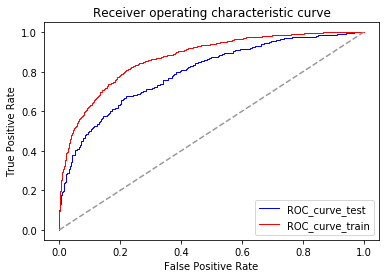

In [175]:
######ROC曲线######
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas_test =  best_xgb_model.fit(x_train, y_train).predict_proba(x_test)
probas_train =  best_xgb_model.fit(x_train, y_train).predict_proba(x_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:, 1])

fpr_train, tpr_train, thresholds_raint = roc_curve(y_train, probas_train[:, 1])

#mean_tpr += interp(mean_fpr, fpr, tpr)
#mean_tpr[0] = 0.0 
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
print(roc_auc_test)
print(roc_auc_train)
    
#plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.plot(fpr_test, tpr_test, lw=1, label='ROC_curve_test',color='blue') 
plt.plot(fpr_train, tpr_train, lw=1, label='ROC_curve_train',color='red')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
 
#mean_tpr /= len(cv) 
#mean_tpr[-1] = 1.0 
#mean_auc = auc(mean_fpr, mean_tpr)

#plt.plot(mean_fpr, mean_tpr, 'k--',
         #label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [224]:
def plot_ks(y_test, y_score, positive_flag):
    # 对y_test,y_score重新设置索引
    y_test.index = np.arange(len(y_test))
    y_score.index = np.arange(len(y_score))
    # 构建目标数据集
    target_data = pd.DataFrame({'y_test':list(y_test.iloc[:,0]), 'y_score':list(y_score.iloc[:,0])})
    # 按y_score降序排列
    target_data.sort_values(by = 'y_score', ascending = False, inplace = True)
    # 自定义分位点
    cuts = np.arange(0.1,1,0.1)
    # 计算各分位点对应的Score值
    index = len(target_data.y_score)*cuts
    scores = target_data.y_score.iloc[index.astype('int')]
    # 根据不同的Score值，计算Sensitivity和Specificity
    Sensitivity = []
    Specificity = []
    difference=[]
    for score in scores:
        # 正例覆盖样本数量与实际正例样本量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        # 负例覆盖样本数量与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
        difference.append((positive_recall/positive)-(negative_recall/negative))
    # 构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity),
                               'ks':np.array(Sensitivity)-(1-np.array(Specificity)),
                               'difference':np.array(difference)})
    # 寻找Sensitivity和1-Specificity之差的最大值索引
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
    plt.plot([0]+cuts.tolist(), [0]+plot_data.ks.tolist(), label = 'ks')
    # 添加参考线
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index],
               ymax = plot_data.y2[max_ks_index], linestyles = '--')
    # 添加文本信息
    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
    # 显示图例
    plt.legend()
    
    # 显示图形
    
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


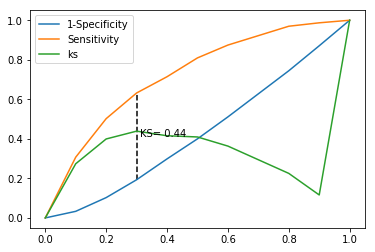

In [223]:
plot_ks(y_test=y_test, y_score=y_score, positive_flag=1)

# 使用kfold进行5折交叉验证

In [102]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate

In [103]:
from sklearn.cross_validation import KFold

In [104]:
kf = KFold(data_x_std_byiv.shape[0], n_folds=5, shuffle=True, random_state=5)

In [156]:
row=0
for i,(train, test) in enumerate(kf):
    x_train=data_x_std_byiv.loc[train]
    y_train=data_y.loc[train]
    x_test=data_x_std_byiv.loc[test]
    y_test=data_y.loc[test]
    best_xgb_model.fit(x_train,y_train)
    y_pred=best_xgb_model.predict(x_test)
    y_pred_proba=best_xgb_model.predict_proba(x_test)[:,1]
    acc,p,r,f1=evaluate(y_pred,y_test)
    auc=roc_auc_score(y_test,y_pred_proba)
    df_result.loc[row]=[acc,p,r,f1,auc]
    row+=1
df_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.794953,0.626087,0.321429,0.424779,0.789583
1,0.804416,0.742647,0.400794,0.520619,0.798414
2,0.817035,0.696296,0.414097,0.519337,0.807628
3,0.793901,0.706294,0.396078,0.507538,0.802372
4,0.784211,0.625000,0.319149,0.422535,0.764589


In [158]:
df_result.mean()

accuracy         0.798903
precision        0.679265
recall           0.370309
f1_score         0.478961
roc_auc_score    0.792517
dtype: float64

In [106]:
df_result=pd.DataFrame(columns=['accuracy','precision','recall','f1_score','roc_auc_score'])

# 使用cross_val_score进行5折交叉验证

In [137]:
def muti_score(model):
    accuracy = cross_val_score(model, data_x_std_byiv, data_y, scoring='accuracy', cv=5)
    precision = cross_val_score(model, data_x_std_byiv, data_y, scoring='precision', cv=5)
    recall = cross_val_score(model, data_x_std_byiv, data_y, scoring='recall', cv=5)
    f1_score = cross_val_score(model, data_x_std_byiv, data_y, scoring='f1', cv=5)
    auc = cross_val_score(model, data_x_std_byiv, data_y, scoring='roc_auc', cv=5)
    return list((sum(accuracy)/5,sum(precision)/5,sum(recall)/5,sum(f1_score)/5,sum(auc)/5))

In [138]:
parms_df=pd.DataFrame({'LR':best_model['lr_model'],'svm':best_model['svm_model'],
                       'knn':best_model['knn_model'],'decision tree':best_model['dt_model'],
                       'xgboost':best_model['xgb_model'],'random forest':best_model['rf_model']})

In [139]:
best_model

{'lr_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'svm_model': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'knn_model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=10, p=2,
            weights='distance'),
 'dt_model': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fract

In [140]:
muti_score(best_model['xgb_model'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sa

[0.8010082722114248,
 0.6847218811463626,
 0.38476495200590694,
 0.49244476024118056,
 0.7925241367934255]

In [153]:
score_df=pd.DataFrame(columns=['accuracy','precision','recall','f1_score','roc_auc_score'])

In [154]:
score_df

,accuracy,precision,recall,f1_score,roc_auc_score


In [155]:
for name,model in best_model.items():
    score_df.loc[name]=muti_score(model)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

In [157]:
score_df

,accuracy,precision,recall,f1_score,roc_auc_score
lr_model,0.794700,0.692517,0.327763,0.444696,0.787357
svm_model,0.793650,0.736259,0.279150,0.403906,0.749959
knn_model,0.783971,0.644572,0.310168,0.418272,0.730812
dt_model,0.702351,0.412748,0.426666,0.420242,0.609715
xgb_model,0.801008,0.684722,0.384765,0.492445,0.792524
rf_model,0.778082,0.772029,0.176028,0.280050,0.776158


可以看出，xgboost是最好的模型